# Общий ноутбук с полным решением продуктового анализа велопроката

## Команда

Название:

**Бигдатка**

Участники:
* **Калугин Константин** - Тимлид, ответственный за станции
* **Зейгман Константин** - Ответственный за байки
* **Муляр Никита** - Ответственный за целевую аудиторию

Ментор:

**Ермаков Егор**

## Предисловие

Необходимо разбить решение на следующие части:
1. Обработка сырого датасета, приведение всех данных к единому стандарту для более удобной работы и автоматизации вычислений
2. Разведочный анализ данных, чтобы понять, с какими данными можно поработать
3. Анализ станций
4. Определение портрета целевой аудитории
5. Анализ типов велосипедов
6. Проанализировать экономику велопроката
7. Сделать выводы

Анализ датасета будет состоять из двух частей: выдвижение гипотезы и ее подтверждение (или опровержение, что тоже хорошо)

## Решение

### Обработка датасета

#### Проблема

1. Таблицы за 2013-2019 года отличаются по присутствующим данным от таблиц за 2020-2022 год
2. В некоторых таблицах данные представлены с кавычками
3. В таблицах за 2013-2019 года некоторая информация о станциях находится в других файлах

#### Решение проблемы

Определяем библиотеки, которые будут задействованы для обработки датасета

In [11]:
from pyspark import SparkConf, SparkContext
import os
import datetime
import shutil
import pandas as pd
import numpy as np
import requests
import networkx as nx
from IPython.display import Image
import matplotlib.pyplot as plt
from math import floor

Определяем функции, которые будут задествованы для стандартизации записи данных

In [2]:
def filter_first_2013_2019(line):
    try:
        first_elem = int(line[0])
        return True
    except:
        return False


def filter_first_2020_2023(line):
    if line[0] == 'ride_id':
        return False
    return True


def del_quotation_marks(elems):
    for i in range(len(elems)):
        if '"' in elems[i]:
            elems[i] = elems[i][1:-1]
    return elems


def map_2013_2019(elems):
    try:
        if '/' not in elems[1]:
            if len(elems[1].split()[1]) != 8:
                return ','.join([elems[0], '', datetime.datetime.strptime(elems[1], "%Y-%m-%d %H:%M").isoformat(),
                                 datetime.datetime.strptime(elems[2], "%Y-%m-%d %H:%M").isoformat(), elems[-6],
                                 elems[-4], '', '', '', '', elems[-3], elems[-2],
                                 str(datetime.datetime.strptime(elems[1], "%Y-%m-%d %H:%M").year - int(elems[-1])) if elems[-1] else '', elems[3]])
            else:
                return ','.join([elems[0], '', datetime.datetime.strptime(elems[1], "%Y-%m-%d %H:%M:%S").isoformat(),
                                 datetime.datetime.strptime(elems[2], "%Y-%m-%d %H:%M:%S").isoformat(), elems[-6],
                                 elems[-4], '', '', '', '', elems[-3], elems[-2],
                                 str(datetime.datetime.strptime(elems[1], "%Y-%m-%d %H:%M:%S").year - int(elems[-1])) if elems[-1] else '', elems[3]])
        else:
            if elems[1][-3] == ':' and elems[1][-6] == ':':
                return ','.join([elems[0], '', datetime.datetime.strptime(elems[1], "%m/%d/%Y %H:%M:%S").isoformat(),
                                 datetime.datetime.strptime(elems[2], "%m/%d/%Y %H:%M:%S").isoformat(), elems[-6],
                                 elems[-4], '', '', '', '', elems[-3], elems[-2],
                                 str(datetime.datetime.strptime(elems[1], "%m/%d/%Y %H:%M:%S").year - int(elems[-1])) if elems[-1] else '', elems[3]])
            else:
                return ','.join([elems[0], '', datetime.datetime.strptime(elems[1], "%m/%d/%Y %H:%M").isoformat(),
                             datetime.datetime.strptime(elems[2], "%m/%d/%Y %H:%M").isoformat(), elems[-6],
                             elems[-4], '', '', '', '', elems[-3], elems[-2],
                             str(datetime.datetime.strptime(elems[1], "%m/%d/%Y %H:%M").year - int(elems[-1])) if elems[-1] else '', elems[3]])
    except:
        return ''


def map_2020_2023(elems):
     try:
        return ','.join([elems[0], elems[1], datetime.datetime.strptime(elems[2], "%Y-%m-%d %H:%M:%S").isoformat(),
                         datetime.datetime.strptime(elems[3], "%Y-%m-%d %H:%M:%S").isoformat(),
                         elems[4], elems[6], elems[8], elems[9],
                         elems[10], elems[11], elems[12], '', '', ''])
     except:
         return ''

Определяем функции, которые будут задействованы для получения координат станций (требуется для 2013-2019 годов)

In [3]:
def mapper_st(line):
    info = line.split(",")
    if info[0].isnumeric() and info[1] != "" and info[2] != "" and info[3] != "":
        yield (info[0], (info[1], info[2], info[3]))

def mapper_tr(line):
    id_, type_, started_at, ended_at, start_name, end_name, start_lat, start_lng, end_lat, end_lng, member_casul, gender, age, bikeid = line.split(",")
    return {
        "id": int(id_),
        "type": type_,
        "started_at": started_at,
        "ended_at": ended_at,
        "start_name": start_name,
        "end_name": end_name,
        "member_casul": member_casul,
        "gender": gender,
        "age": age,
        "bikeid": bikeid
    }

def mapper_inter(line):
    from_name, (data, station) = line
    return {
        "id": data["id"],
        "type": data["type"],
        "started_at": data["started_at"],
        "ended_at": data["ended_at"],
        "start_name": data["start_name"],
        "end_name": data["end_name"],
        "start_lat": station["latitude"] if station else "",
        "start_lng": station["longitude"] if station else "",
        "member_casul": data["member_casul"],
        "gender": data["gender"],
        "age": data["age"],
        "bikeid": data["bikeid"]
    }

def mapper_st_final(x):
    return {
        "name": x[1][0],
        "latitude": x[1][1],
        "longitude": x[1][2]
    }

def finalise(line):
    to_name, (data, station) = line
    return ",".join([str(x) for x in [
        data["id"],
        data["type"],
        data["started_at"],
        data["ended_at"],
        data["start_name"],
        data["end_name"],
        data["start_lat"],
        data["start_lng"],
        station["latitude"] if station else "",
        station["longitude"] if station else "",
        data["member_casul"],
        data["gender"],
        data["age"],
        data["bikeid"]
    ]])


Определяем функцию, которая реализует описанные выше функции для стандартизации

In [4]:
def get_data():
    directory ='sources/'
    # 2013 - 2019
    for i in range(2013, 2020):
        files = None
        try:
            for filename in os.listdir(directory):
                if str(i) not in filename:
                    continue
                file = sc.textFile(os.path.join(directory, filename)) \
                    .map(lambda line: line.split(',')) \
                    .map(del_quotation_marks) \
                    .filter(filter_first_2013_2019)
                if files is None:
                    files = file
                else:
                    files = files.union(file)
            res = files.map(map_2013_2019).filter(lambda x: x != '')
            res.coalesce(1).saveAsTextFile(f'clean_sources/{i}')
        except:
            pass
    # 2020 - 2023
    for i in range(2020, 2024):
        files = None
        try:
            for filename in os.listdir(directory):
                if str(i) not in filename:
                    continue
                file = sc.textFile(os.path.join(directory, filename)) \
                    .map(lambda line: line.split(',')) \
                    .map(del_quotation_marks) \
                    .filter(filter_first_2020_2023)
                if files is None:
                    files = file
                else:
                    files = files.union(file)
            res = files.map(map_2020_2023).filter(lambda x: x != '')
            res.coalesce(1).saveAsTextFile(f'clean_sources/{i}')
        except:
            pass

Определяем цункцию, которая будет использоваться для получения координат и добавления ее к датасету

In [5]:
def bind_data():
    # собрать данные о станциях
    stations = sc.textFile("stations").flatMap(mapper_st) \
                                      .reduceByKey(lambda a, b: a) \
                                      .map(mapper_st_final)
    stations_key = stations.keyBy(lambda x: x["name"])
    for y in range(2013, 2019 + 1):
        try:
            df = sc.textFile(f"clean_sources/{y}").map(mapper_tr)
            df_from = df.keyBy(lambda x: x["start_name"])
            inter = df_from.leftOuterJoin(stations_key) \
                .map(mapper_inter)
            df_to = inter.keyBy(lambda x: x["end_name"])
            final = df_to.leftOuterJoin(stations_key) \
                .map(finalise) \
                .coalesce(1) \
                .saveAsTextFile(f"binded_data/{y}")
        except:
            pass

Собираем все полученные таблицы в одной папке, остальные удаляем

In [6]:
def unity():
    os.makedirs('data/src')
    for i in range(2013, 2020):
        os.rename(f'binded_data/{i}', f'data/src/{i}')
    for i in range(2020, 2024):
        os.rename(f'clean_sources/{i}', f'data/src/{i}')
    shutil.rmtree('binded_data')
    shutil.rmtree('clean_sources')

Запускаем обработку данных

In [7]:
conf = SparkConf().setAppName('test').setMaster('local')
sc = SparkContext(conf=conf)
get_data()
bind_data()
unity()

23/04/15 18:01:11 WARN Utils: Your hostname, bigdata resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
23/04/15 18:01:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/15 18:01:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


В итоге мы оставляем следующие колонки:
1. id - уникальный идентификатор поездки
2. biketype - тип велосипеда
3. starttime - время начала поездки
4. endtime - время окончания поездки
5. startstation - название стартовой станции
6. endstation- название конечной станции
7. startlat, startlng - координаты стартовой станции
8. endlat, endlng - координаты конечной станции
9. member_casual - тип пользователя
10. age - возраст пользователя
11. gender - пол пользователя
12. bikeid - уникальный идентификатор велосипеда

### Разведочный анализ

#### Цели

1. Определить основные направления исследований
2. Определить какая информация может отсутствовать в различные временные интервалы
3. Определить, какие временные интервалы подходят под те или иные направления

#### Достижение цели

Посмотрим, как выглядят данные за различные годы

In [12]:
for year in range(2013, 2024):
    df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')
    print(year)
    print(df.head())
    print()

2013
     id  biketype            starttime              endtime  \
0  8163       NaN  2013-06-29T13:22:00  2013-06-29T13:45:00   
1  8164       NaN  2013-06-29T13:22:00  2013-06-29T13:45:00   
2  8826       NaN  2013-06-29T16:40:00  2013-06-29T17:19:00   
3  8827       NaN  2013-06-29T16:41:00  2013-06-29T17:19:00   
4  8855       NaN  2013-06-29T16:52:00  2013-06-29T17:27:00   

                startstation             endstation   startlat   startlng  \
0  Lake Shore Dr & Monroe St  Michigan Ave & Oak St  41.880958 -87.616743   
1  Lake Shore Dr & Monroe St  Michigan Ave & Oak St  41.880958 -87.616743   
2  Lake Shore Dr & Monroe St  Michigan Ave & Oak St  41.880958 -87.616743   
3  Lake Shore Dr & Monroe St  Michigan Ave & Oak St  41.880958 -87.616743   
4  Lake Shore Dr & Monroe St  Michigan Ave & Oak St  41.880958 -87.616743   

     endlat     endlng member_casual gender  age  bikeid  
0  41.90096 -87.623777      Customer    NaN  NaN     153  
1  41.90096 -87.623777      Custome

/tmp/ipykernel_3010/3800461909.py:2: DtypeWarning: Columns (6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')


2015
        id  biketype            starttime              endtime  \
0  6519525       NaN  2015-07-27T19:31:00  2015-07-27T19:52:00   
1  6519506       NaN  2015-07-27T19:30:00  2015-07-27T19:51:00   
2  6153984       NaN  2015-07-10T17:31:00  2015-07-10T17:49:00   
3  6135776       NaN  2015-07-09T20:19:00  2015-07-09T20:31:00   
4  7717137       NaN  2015-09-28T23:07:00  2015-09-28T23:19:00   

               startstation              endstation   startlat   startlng  \
0  Racine Ave & Belmont Ave  Halsted St & Willow St  41.939743 -87.658865   
1  Racine Ave & Belmont Ave  Halsted St & Willow St  41.939743 -87.658865   
2  Racine Ave & Belmont Ave  Halsted St & Willow St  41.939743 -87.658865   
3  Racine Ave & Belmont Ave  Halsted St & Willow St  41.939743 -87.658865   
4  Racine Ave & Belmont Ave  Halsted St & Willow St  41.939743 -87.658865   

      endlat    endlng member_casual  gender   age  bikeid  
0  41.913778 -87.64884      Customer     NaN   NaN    2301  
1  41.913778 

/tmp/ipykernel_3010/3800461909.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')


2016
        id  biketype            starttime              endtime  \
0  9078002       NaN  2016-03-31T17:35:00  2016-03-31T17:44:00   
1  9076949       NaN  2016-03-31T16:51:00  2016-03-31T17:01:00   
2  9068622       NaN  2016-03-30T16:35:00  2016-03-30T16:45:00   
3  9058980       NaN  2016-03-29T17:36:00  2016-03-29T17:45:00   
4  9057940       NaN  2016-03-29T17:00:00  2016-03-29T17:09:00   

               startstation              endstation     startlat   startlng  \
0  Clark St & Congress Pkwy  Michigan Ave & 18th St  41.87593267 -87.630585   
1  Clark St & Congress Pkwy  Michigan Ave & 18th St  41.87593267 -87.630585   
2  Clark St & Congress Pkwy  Michigan Ave & 18th St  41.87593267 -87.630585   
3  Clark St & Congress Pkwy  Michigan Ave & 18th St  41.87593267 -87.630585   
4  Clark St & Congress Pkwy  Michigan Ave & 18th St  41.87593267 -87.630585   

      endlat     endlng member_casual gender   age  bikeid  
0  41.857937 -87.623633    Subscriber   Male  38.0    3735  
1

/tmp/ipykernel_3010/3800461909.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')


2017
         id  biketype            starttime              endtime  \
0  16706263       NaN  2017-09-29T11:30:18  2017-09-29T11:32:12   
1  16703853       NaN  2017-09-29T08:48:33  2017-09-29T08:51:13   
2  16698675       NaN  2017-09-28T20:58:59  2017-09-28T21:00:45   
3  16690364       NaN  2017-09-28T15:20:49  2017-09-28T15:22:34   
4  16689386       NaN  2017-09-28T14:11:03  2017-09-28T14:14:17   

                startstation            endstation     startlat   startlng  \
0  Franklin St & Chicago Ave  Wells St & Walton St  41.89680204 -87.635638   
1  Franklin St & Chicago Ave  Wells St & Walton St  41.89680204 -87.635638   
2  Franklin St & Chicago Ave  Wells St & Walton St  41.89680204 -87.635638   
3  Franklin St & Chicago Ave  Wells St & Walton St  41.89680204 -87.635638   
4  Franklin St & Chicago Ave  Wells St & Walton St  41.89680204 -87.635638   

     endlat    endlng member_casual  gender   age  bikeid  
0  41.89993 -87.63443    Subscriber    Male  22.0    5997  
1  

/tmp/ipykernel_3010/3800461909.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')


2018
         id  biketype            starttime              endtime  \
0  17751261       NaN  2018-02-22T18:51:00  2018-02-22T18:57:36   
1  17776531       NaN  2018-02-27T07:44:47  2018-02-27T07:51:32   
2  17919522       NaN  2018-03-20T07:49:21  2018-03-20T07:56:13   
3  17933889       NaN  2018-03-22T07:48:35  2018-03-22T07:55:45   
4  17951928       NaN  2018-03-24T19:50:05  2018-03-24T19:56:29   

                 startstation                endstation     startlat  \
0  Wilton Ave & Diversey Pkwy  Racine Ave & Belmont Ave  41.93250008   
1  Wilton Ave & Diversey Pkwy  Racine Ave & Belmont Ave  41.93250008   
2  Wilton Ave & Diversey Pkwy  Racine Ave & Belmont Ave  41.93250008   
3  Wilton Ave & Diversey Pkwy  Racine Ave & Belmont Ave  41.93250008   
4  Wilton Ave & Diversey Pkwy  Racine Ave & Belmont Ave  41.93250008   

    startlng     endlat     endlng member_casual  gender   age  bikeid  
0 -87.652681  41.939743 -87.658865    Subscriber    Male  26.0    4714  
1 -87.652681 

/tmp/ipykernel_3010/3800461909.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')


2019
         id  biketype            starttime              endtime  \
0  23498594       NaN  2019-07-01T19:36:49  2019-07-01T19:39:50   
1  23500777       NaN  2019-07-01T21:34:23  2019-07-01T21:36:15   
2  23516824       NaN  2019-07-02T17:59:25  2019-07-02T18:01:51   
3  23556460       NaN  2019-07-04T18:50:20  2019-07-04T18:52:35   
4  23669073       NaN  2019-07-10T17:50:48  2019-07-10T17:53:16   

                     startstation                   endstation   startlat  \
0  California Ave & Milwaukee Ave  California Ave & Francis Pl  41.922695   
1  California Ave & Milwaukee Ave  California Ave & Francis Pl  41.922695   
2  California Ave & Milwaukee Ave  California Ave & Francis Pl  41.922695   
3  California Ave & Milwaukee Ave  California Ave & Francis Pl  41.922695   
4  California Ave & Milwaukee Ave  California Ave & Francis Pl  41.922695   

    startlng    endlat    endlng member_casual gender   age  bikeid  
0 -87.697153  41.91855 -87.69723    Subscriber   Male  30.0

Заметим, что помимо очевидных пропусков в данных за различные периоды, можно заметить, что члены и нечлены помечаются по-разному.

Проверим это ниже

In [13]:
for year in range(2013, 2024):
    df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')
    print(year)
    print(df['member_casual'].unique())
    print()

2013
['Customer' 'Subscriber']

2014
['Subscriber' 'Customer']



/tmp/ipykernel_3010/1532442150.py:2: DtypeWarning: Columns (6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')


2015
['Customer' 'Subscriber' 'Dependent']



/tmp/ipykernel_3010/1532442150.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')


2016
['Subscriber' 'Customer' 'Dependent']



/tmp/ipykernel_3010/1532442150.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')


2017
['Subscriber' 'Customer' 'Dependent']



/tmp/ipykernel_3010/1532442150.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')


2018
['Subscriber' 'Customer']



/tmp/ipykernel_3010/1532442150.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')


2019
['Subscriber' 'Customer']

2020
['member' 'casual']

2021
['member' 'casual']

2022
['member' 'casual']

2023
['member' 'casual']



Члены могут быть отмечены в логах как "member" или как "Subscriber", а нечлены - как "Customer" или как "casual". Также один раз встречается "Depended", но он не представляет для нас никакого интереса в конечном счете

Определим, как менялось с годами количество станций

In [14]:
counts_stations = []
for year in range(2013, 2024):
    df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')
    counts_stations.append(len(np.unique(np.concatenate((df['startstation'].dropna().unique(), df['endstation'].dropna().unique()), axis=None))))

/tmp/ipykernel_3010/1720053798.py:3: DtypeWarning: Columns (6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')
/tmp/ipykernel_3010/1720053798.py:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')
/tmp/ipykernel_3010/1720053798.py:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, 

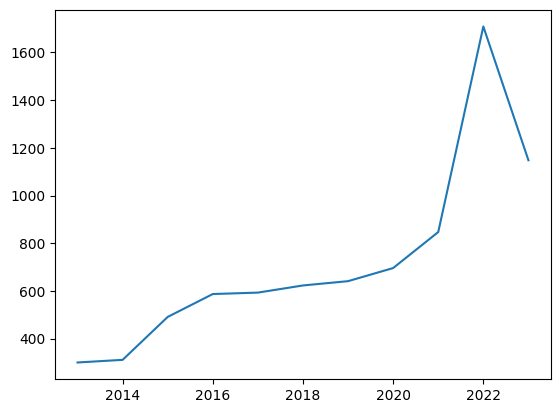

In [17]:
plt.plot(range(2013, 2024), counts_stations)

Как мы видим по графику, количество станций растет. Падение в конце же обусловлено тем, что мы имеем за последний год только 3 месяца, вместо 12, из-за было собрано мало данных

Однако именно на информации за 2023 мы будем основываться в анализе станций, т.к. только с ними мы можем иметь высокую уверенность в том, что станции не были закрыты (к тому же по выборка достаточно большая, что делает ее репрезентативной)

Посмотрим на то, как могут строиться маршруты

In [18]:
df = pd.read_table(f'data/src/2023/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')

In [19]:
stations = df[['startstation', 'endstation']]
stations.rename(columns={'startstation': 'source', 'endstation': 'target'})
graph = nx.Graph()
graph.add_edges_from(stations.to_numpy())

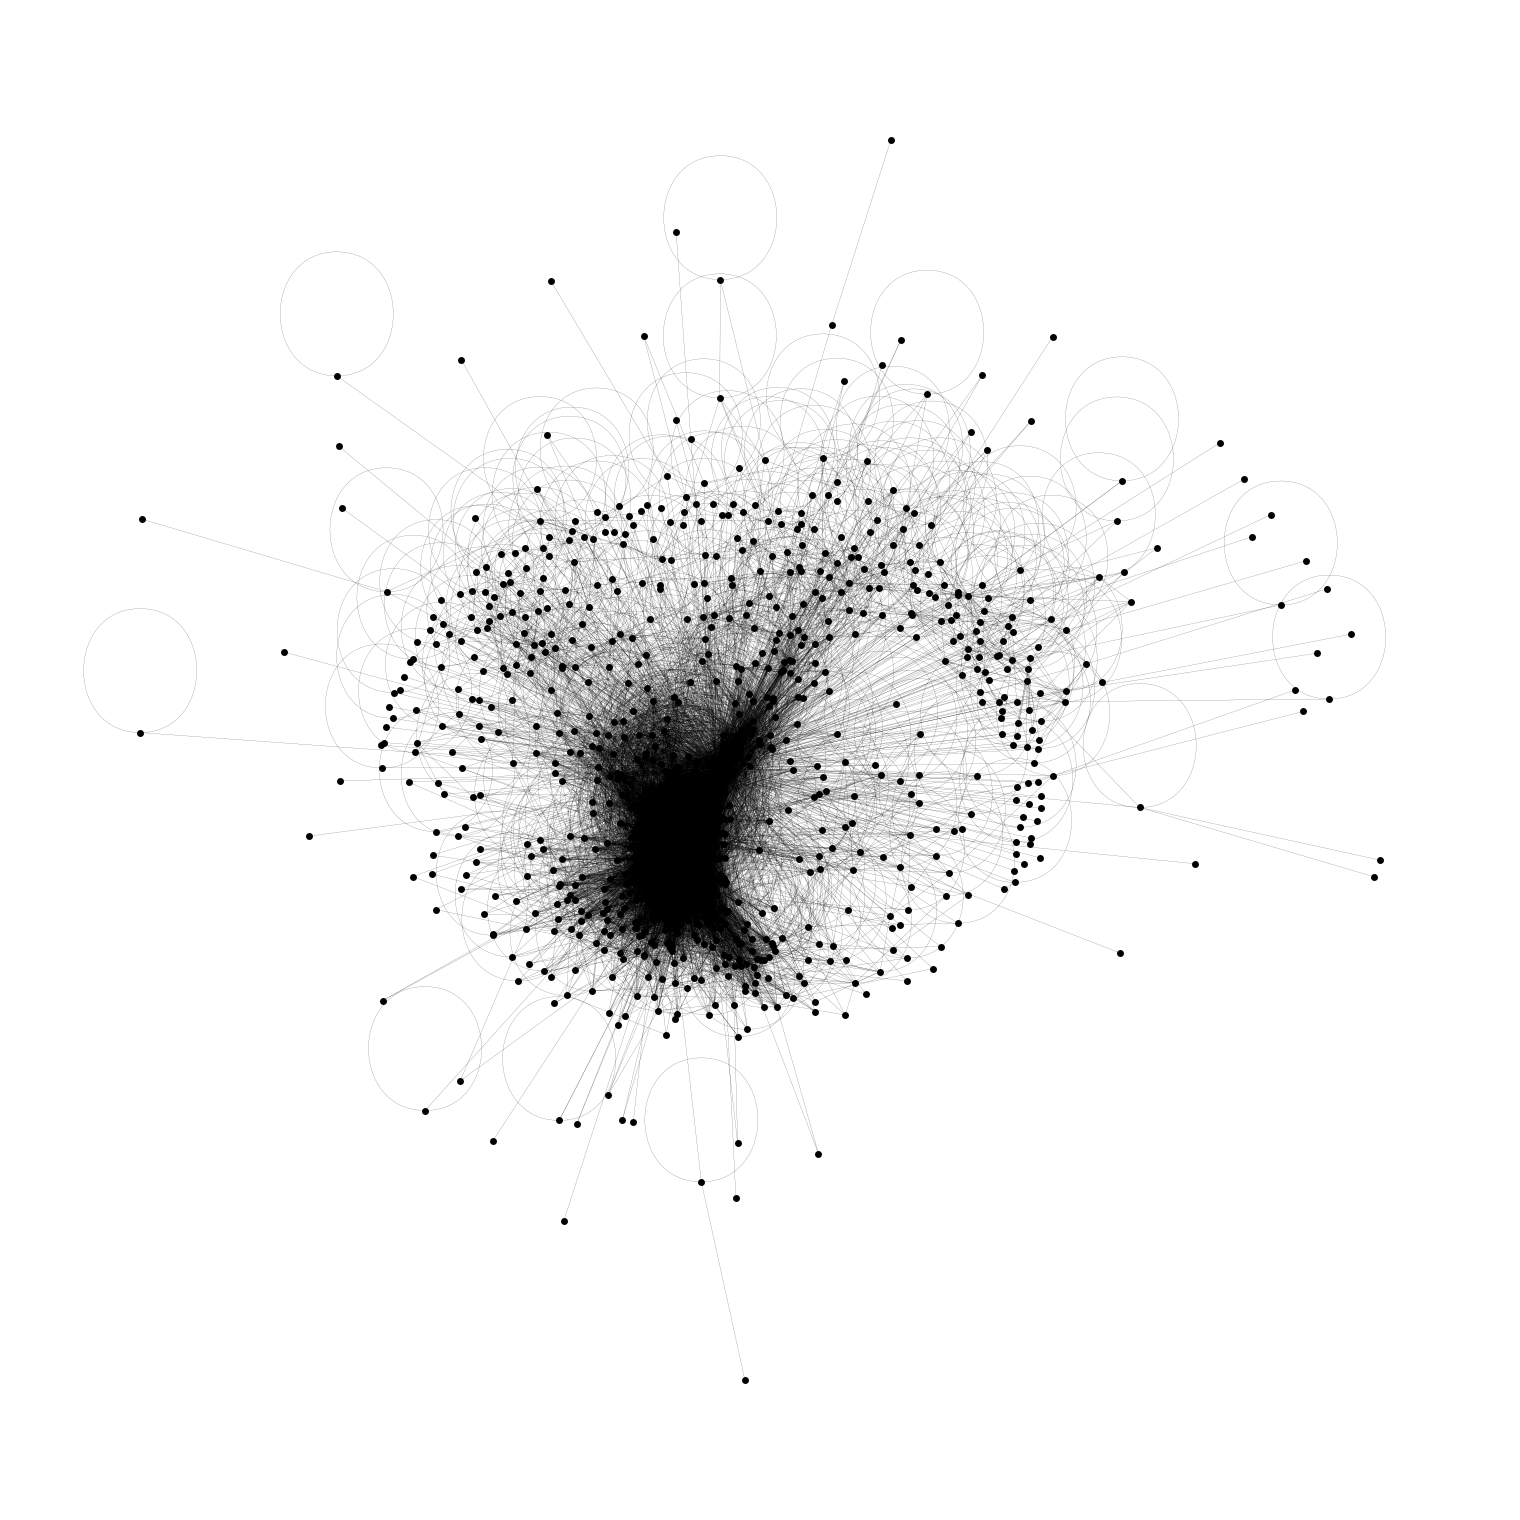

In [20]:
plt.figure(figsize=(15,15))
options = {"node_color": "black", "node_size": 25, "linewidths": 0, "width": 0.1}
pos = nx.spring_layout(graph, seed=1969)
nx.draw(graph, pos, **options)

Как мы видим, в логгах встречаются прогулочные сессии (т.е. человек начал ее и закончил в одном пункте), а также на гарфе мы видим висячие вершины, что говорит о том, что некоторые станции использовались для связи лишь с одним пунктом.

### Целевая аудитория

In [21]:
members = []
casuals = []
for year in range(2013, 2024):
    df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')
    casuals.append(len(df.loc[(df['member_casual'] == 'Customer') | (df['member_casual'] == 'casual')]))
    members.append(len(df.loc[(df['member_casual'] == 'Subscriber') | (df['member_casual'] == 'member')]))

/tmp/ipykernel_3010/4032614782.py:4: DtypeWarning: Columns (6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')
/tmp/ipykernel_3010/4032614782.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')
/tmp/ipykernel_3010/4032614782.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, 

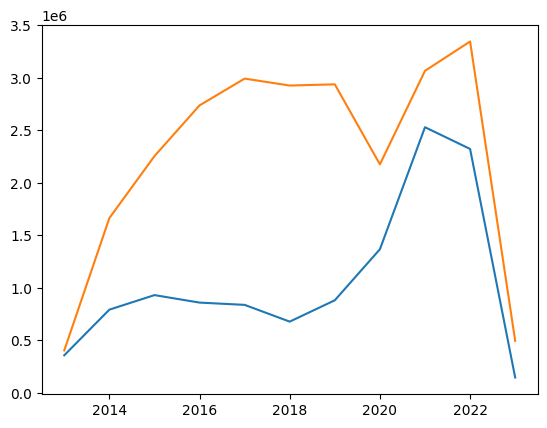

In [22]:
plt.plot(range(2013, 2024), casuals)
plt.plot(range(2013, 2024), members)
plt.show()

In [23]:
age_hist = None
for year in range(2013, 2020):
    df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')
    if year == 2013:
        age_hist = df[['id', 'age']].dropna().groupby(by=['age']).count()
    else:
        age = df[['id', 'age']].dropna().groupby(by=['age']).count()
        age_hist = pd.concat([age_hist, age]).reset_index().groupby(by='age').sum()

/tmp/ipykernel_3010/971531240.py:3: DtypeWarning: Columns (6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')
/tmp/ipykernel_3010/971531240.py:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')
/tmp/ipykernel_3010/971531240.py:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, hea

In [24]:
res = age_hist.reset_index()
res = res[res['age'] < 100]

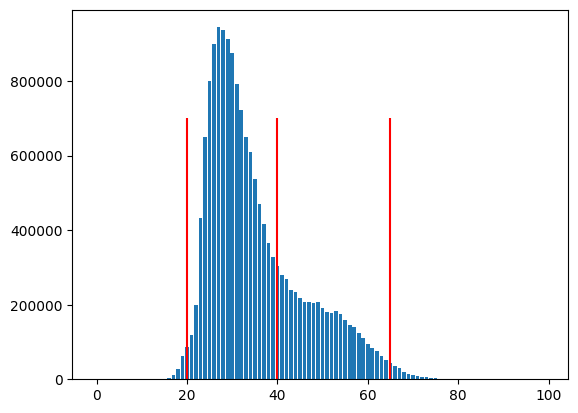

In [25]:
plt.bar(res['age'], res['id'])
plt.vlines(20, 0, 700000, color='r')
plt.vlines(40, 0, 700000, color='r')
plt.vlines(65, 0, 700000, color='r')

In [26]:
types = {"<20": [0, 0], "20-39": [0, 0], "40-64": [0, 0], ">=65": [0, 0]}
for year in range(2013, 2020):
    df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')[['age', 'member_casual']]
    types['<20'][0] += len(df[(df['age'] < 20) & (df['member_casual'] == 'Customer')])
    types['<20'][1] += len(df[(df['age'] < 20) & (df['member_casual'] == 'Subscriber')])
    types['20-39'][0] += len(df[(df['age'] >= 20) & (df['age'] < 40) & (df['member_casual'] == 'Customer')])
    types['20-39'][1] += len(df[(df['age'] >= 20) & (df['age'] < 40) & (df['member_casual'] == 'Subscriber')])
    types['40-64'][0] += len(df[(df['age'] >= 40) & (df['age'] < 65) & (df['member_casual'] == 'Customer')])
    types['40-64'][1] += len(df[(df['age'] >= 40) & (df['age'] < 65) & (df['member_casual'] == 'Subscriber')])
    types['>=65'][0] += len(df[(df['age'] >= 65) & (df['member_casual'] == 'Customer')])
    types['>=65'][1] += len(df[(df['age'] >= 65) & (df['member_casual'] == 'Subscriber')])

/tmp/ipykernel_3010/984344956.py:3: DtypeWarning: Columns (6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')[['age', 'member_casual']]
/tmp/ipykernel_3010/984344956.py:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')[['age', 'member_casual']]
/tmp/ipykernel_3010/984344956.py:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table

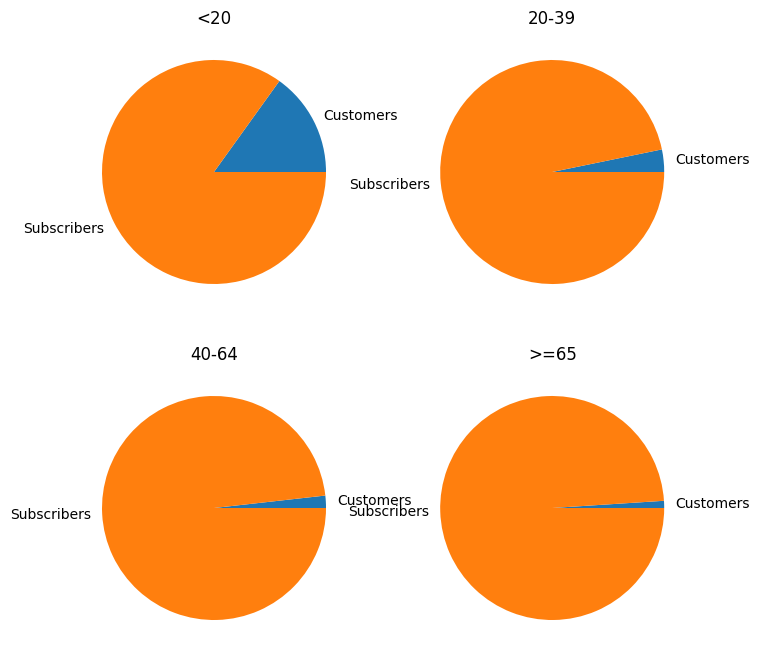

In [27]:
i = 1
plt.figure(figsize=(8, 8))
for tp in list(types.keys()):
    plt.subplot(2, 2, i)
    plt.title(tp)
    plt.pie(types[tp], labels=['Customers', 'Subscribers'])
    i += 1

In [28]:
types = None
res = None
for year in range(2020, 2024):
    df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')
    types = df[['biketype', 'member_casual']]
    classes = pd.get_dummies(types['member_casual'])
    types = types.join(classes)
    types = types[['biketype', 'casual', 'member']].groupby(by='biketype').sum()
    if res is None:
        res = types
    else:
        res = pd.concat([res, types]).groupby(by='biketype').sum()
res

,casual,member
biketype,,
classic_bike,2218334,3991789
docked_bike,1642799,1820293
electric_bike,2501704,3268968


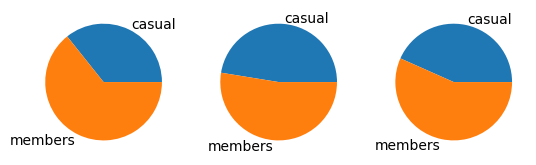

In [29]:
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.pie(res.iloc[i].tolist(), labels=['casual', 'members'])

In [30]:
res = None
for year in range(2020, 2024):
    df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')
    types = df[['biketype', 'id']].groupby(by='biketype').count()
    if res is None:
        res = types
    else:
        res = pd.concat([res, types]).groupby(by='biketype').sum()
res

,id
biketype,
classic_bike,6210123
docked_bike,3463092
electric_bike,5770672


([<matplotlib.patches.Wedge at 0x7f1ce4d14e50>,
 [Text(0.3329804101735338, 1.048391170527807, 'classic_bike'),
  Text(-1.095607807006059, -0.09820149299971943, 'docked_bike'),
  Text(0.42524506127276435, -1.0144785053726486, 'electric_bike')])

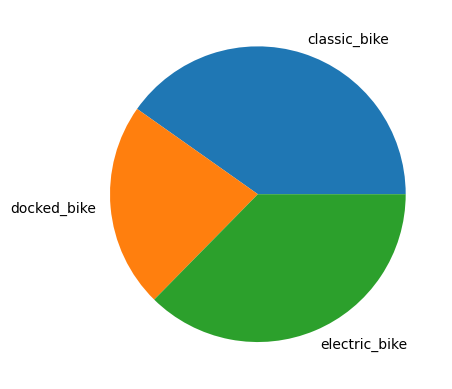

In [31]:
plt.pie(res['id'].tolist(), labels=res.reset_index()['biketype'].tolist())

In [32]:
res = []
percent_res = []
points = []
for year in range(2013, 2024):
    df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')
    df = df[['startstation', 'endstation', 'startlat', 'startlng']].dropna()
    full = len(df)
    df = df[df['startstation'] == df['endstation']]
    points.extend((df['startlng'].astype(str) + ',' + df['startlat'].astype(str)).tolist())
    points = list(set(points))
    res.append(len(df))
    percent_res.append(len(df) / full)

/tmp/ipykernel_3010/1594772344.py:5: DtypeWarning: Columns (6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')
/tmp/ipykernel_3010/1594772344.py:5: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')
/tmp/ipykernel_3010/1594772344.py:5: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, 

In [33]:
print(sum(res) / 10.25)
print(sum(percent_res) / 10.25)

167669.75609756098
0.056075698962058565


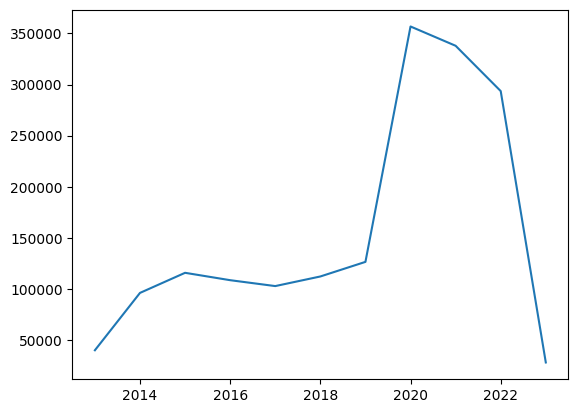

In [34]:
plt.plot(range(2013, 2024), res)

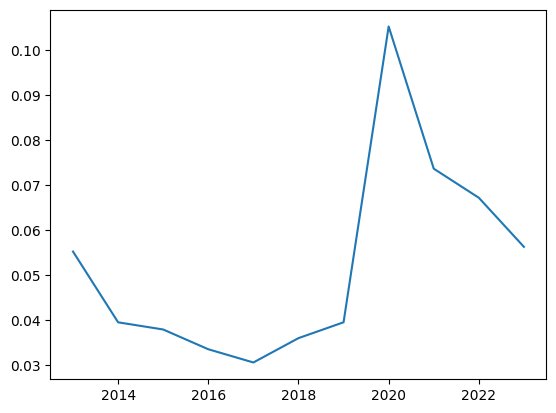

In [35]:
plt.plot(range(2013, 2024), percent_res)

In [36]:
import requests


API_SERVER = "http://static-maps.yandex.ru/1.x"


def set_request(points):
    params = {"ll": "-87.623766,41.875732",
              "spn": "0.15,0.15",
              "l": 'map'}
    params['pt'] = '~'.join(points)
    image = requests.get(API_SERVER, params)
    with open('data/map.png', "wb") as file:
        file.write(image.content)

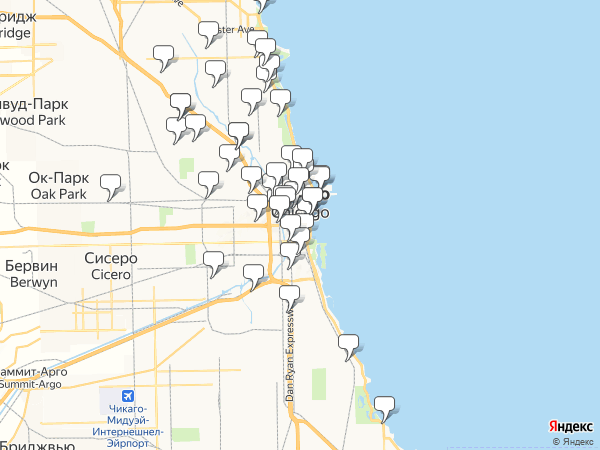

In [37]:
set_request(points[100:150])
from IPython.display import Image
Image(filename='data/map.png')

In [38]:
res = None


def get_price(df):
    df['output'] = (1 + df['output'] * 0.42) if df['biketype'] == 'docked_bike' or df['biketype'] == 'electric_bike' else (1 + df['output'] * 0.17)
    return df


for year in range(2020, 2024):
    df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')
    df = df[['member_casual', 'biketype', 'starttime', 'endtime']].dropna()
    df = df[df['member_casual'] == 'casual']
    df['starttime'] = df['starttime'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S'))
    df['endtime'] = df['endtime'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S'))
    df['output'] = df['endtime'] - df['starttime']
    df = df[['biketype', 'output']].groupby(by='biketype').sum().reset_index()
    df['output'] = df['output'].apply(lambda x: x.total_seconds() / 60)
    df = df.apply(get_price, axis=1)
    if res is None:
        res = df
    else:
        res = pd.concat([res, df]).groupby('biketype').sum().reset_index()
print(res['output'].sum() / 3.25)

22780302.223435897


In [ ]:
conf = SparkConf().setAppName('test').setMaster('local')
sc = SparkContext(conf=conf)

In [ ]:
df = pd.read_table(f'data/src/{2013}/part-00000', index_col=False, header=None,
              names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation',
                     'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age',
                     'bikeid'], sep=',')

for i in range(2014, 2020):
    df2 = pd.read_table(f'data/src/{i}/part-00000', index_col=False, header=None,
              names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation',
                     'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age',
                     'bikeid'], sep=',')
    df = pd.concat([df, df2])

/tmp/ipykernel_4214/626727831.py:7: DtypeWarning: Columns (6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_table(f'data/src/{i}/part-00000', index_col=False, header=None,
/tmp/ipykernel_4214/626727831.py:7: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_table(f'data/src/{i}/part-00000', index_col=False, header=None,
/tmp/ipykernel_4214/626727831.py:7: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_table(f'data/src/{i}/part-00000', index_col=False, header=None,
/tmp/ipykernel_4214/626727831.py:7: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_table(f'data/src/{i}/part-00000', index_col=False, header=None,
/tmp/ipykernel_4214/626727831.py:7: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False

In [ ]:
age_payment = df[['age', 'member_casual']]
age_payment = age_payment.dropna()
age_payment

In [ ]:
age_payment_cust = age_payment[age_payment['member_casual'] == 'Customer']
age_payment_sub = age_payment[age_payment['member_casual'] == 'Subscriber']

age_bins_sub = pd.cut(age_payment_sub['age'],
                    [0, 15, 18, 21, 24, 27, 30, 35, 40, 45, 50, 55, 60, 70, 90, age_payment_sub['age'].max()],
                    include_lowest=True)
age_bins_cust = pd.cut(age_payment_cust['age'],
                    [0, 15, 18, 21, 24, 27, 30, 35, 40, 45, 50, 55, 60, 70, 90, age_payment_cust['age'].max()],
                    include_lowest=True)
age_payment_sub['age_bins'] = age_bins_sub
age_payment_cust['age_bins'] = age_bins_cust

In [ ]:
age_payment_sub = age_payment_sub.groupby('age_bins')['member_casual'].count()
age_payment_cust = age_payment_cust.groupby('age_bins')['member_casual'].count()

plt.figure(figsize=(10, 5))
plt.xlabel('Возрастные отрезки, года')
plt.ylabel('Кол-во поездок, млн')
age_payment_sub.plot()
age_payment_cust.plot()
plt.legend(['Подписчики', 'Работяги'])
plt.show()

In [ ]:
age_time = df[['age', 'starttime', 'endtime']]
age_time['starttime'] = pd.to_datetime(age_time['starttime'])
age_time['endtime'] = pd.to_datetime(age_time['endtime'])
age_time['duration'] = round((age_time['endtime'] - age_time['starttime']).dt.seconds / 60)
age_time2 = age_time[['age', 'duration']]

age_bins = pd.cut(age_time2['age'],
                  [0, 15, 18, 21, 24, 27, 30, 35, 40, 45, 50, 55, 60, 70, 90, age_time2['age'].max()],
                  include_lowest=True)
age_time2['age_bins'] = age_bins
age_time2 = age_time2.dropna().groupby('age_bins')['duration'].mean()
age_time2

In [ ]:
plt.figure(figsize=(10, 5))
plt.xlabel('Возрастные отрезки, года')
plt.ylabel('Продолжит. поездки, мин.')
age_time2.plot()
plt.show()

In [ ]:
age_bins = pd.cut(age_time['age'],
                  [0, 15, 18, 21, 24, 27, 30, 35, 40, 45, 50, 55, 60, 70, 90, 150, age_time['age'].max()],
                  include_lowest=True)
age_time['starttime'] = age_time['starttime'].dt.hour + age_time['starttime'].dt.minute / 60
age_time['age_bins'] = age_bins
age_time = age_time[['age_bins', 'starttime']]
age_time = age_time.dropna().groupby('age_bins')['starttime'].mean()

In [ ]:
plt.figure(figsize=(10, 5))
plt.ylabel('Время начала поездки, в часах суток')
age_time.plot()
plt.show()

In [ ]:
age_gender = df[['age', 'gender']]
age_gender['age_bins'] = pd.cut(age_gender['age'],
                  [0, 15, 18, 21, 24, 27, 30, 35, 40, 45, 50, 55, 60, 70, 90, 150, age_gender['age'].max()],
                  include_lowest=True)
age_gender = age_gender.dropna()
age_male = age_gender[age_gender['gender'] == 'Male'].groupby(['age_bins'])['gender'].count()
age_female = age_gender[age_gender['gender'] == 'Female'].groupby(['age_bins'])['gender'].count()
age_gender

In [ ]:
plt.figure(figsize=(10, 5))
plt.ylabel('Кол-во человек')
age_male.plot()
age_female.plot()
plt.legend(['Мужчины', 'Женщины'])
plt.show()

In [ ]:
stations = df[['startstation', 'id']]
stations['startstation'] = stations['startstation'].dropna()
stations = stations.groupby('startstation').count().sort_values(by='id', ascending=False)
FIRST_N = 10
stations = stations.head(FIRST_N).axes[0].values.tolist()
print(stations)
startstation_age = df[['startstation', 'age']]
startstation_age = startstation_age.dropna().groupby('startstation').mean()
print(startstation_age)

In [ ]:
data = {'station': [], 'age': []}
for i in range(FIRST_N):
    # print(startstation_age.axes[0].values)
    data['age'].append(startstation_age.loc[stations[i]][0])
    data['station'].append(stations[i])
plt.figure(figsize=(25, 5))
plt.ylabel('Возраст пользователей')
df2 = pd.DataFrame(data).set_index('station')
plt.plot(df2)
plt.show()

In [ ]:
df0 = sc.textFile(f'data/src/{2013}/part-00000')
for i in range(2014, 2020):
    df0 = df0.union(sc.textFile(f'data/src/{i}/part-00000'))

df0 = df0.flatMap(parse).filter(lambda tup: tup[0][0] != '' and tup[0][1] != '').\
    map(lambda tup: ((tup[0][0], float(tup[0][1])), 1)).reduceByKey(lambda v1, v2: v1 + v2)\
    .collect()
summ = 0
for i in df0:
    summ += i[1]

data = {'Gender': [], 'Age': [], 'Num': []}
for i in df0:
    perc = round(i[1] / summ * 100, 2)
    if perc > 0:
        data['Gender'].append(i[0][0])
        data['Age'].append(i[0][1])
        data['Num'].append(perc)

        
plt.figure(figsize=(10, 5))
plt.ylabel('% польз. возраста от всех польз.')
df3 = pd.DataFrame(data)
df3_male = df3[df3['Gender'] == 'Male']
df3_female = df3[df3['Gender'] == 'Female']
df3_male = df3_male.groupby('Age')['Num'].sum()
df3_female = df3_female.groupby('Age')['Num'].sum()
df3_female.plot()
df3_male.plot()
plt.legend(['Женщины', 'Мужчины'])
plt.show()

In [ ]:
srednee_dur = []
plt.figure(figsize=(10, 5))
plt.ylabel('Продолжит. поездки в мин.')
for i in range(2013, 2024):
    df = pd.read_table(f'data/src/{i}/part-00000', index_col=False, header=None,
                       names=['id', 'biketype', 'starttime', 'endtime', 'startstation',
                              'endstation',
                              'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender',
                              'age',
                              'bikeid'], sep=',')
    df = df[['endtime', 'starttime', 'age']]
    df['age_bins'] = pd.cut(df['age'],
                  [0, 15, 18, 21, 24, 27, 30, 35, 40, 45, 50, 55, 60, 70, 90, 150],
                  include_lowest=True)
    df['starttime'] = pd.to_datetime(df['starttime'])
    df['endtime'] = pd.to_datetime(df['endtime'])
    df['duration'] = round((df['endtime'] - df['starttime']).dt.seconds / 60)
    print(df)
    df = df.dropna().groupby('age_bins')['duration'].mean()
    df_durs = df.values
    df_durs = df_durs[~np.isnan(df_durs)]
    srednee_dur.append(df_durs.sum() / len(df_durs))
    df.plot()
plt.show()

In [ ]:
plt.xlabel('Год')
plt.ylabel('Средняя продолжительность поездок в мин.')
plt.plot(range(2013, 2024), srednee_dur)
plt.show()

In [ ]:
from pprint import pprint


def parse2(line):
    info = line.split(',')
    dur = (datetime.fromisoformat(info[3]) - datetime.fromisoformat(info[2])).seconds / 60
    return [(dur, (int(info[0]), info[2], info[3], info[-3], info[-2], dur))]


df0 = sc.textFile(f'data/src/2019/part-00000')
df0 = df0.flatMap(parse2).top(20)
pprint(df0)

In [ ]:
sredniy_age = []
for i in range(2013, 2024):
    df = pd.read_table(f'data/src/{i}/part-00000', index_col=False, header=None,
                       names=['id', 'biketype', 'starttime', 'endtime', 'startstation',
                              'endstation',
                              'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender',
                              'age',
                              'bikeid'], sep=',')
    df = df[['age']]
    sredniy_age.append(df['age'].mean())
plt.plot(range(2013, 2024), sredniy_age)
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.ylabel('% польз. возраста от всех польз.')
for i in [2013, 2019]:
    df0 = sc.textFile(f'data/src/{i}/part-00000')
    df0 = df0.flatMap(parse).filter(lambda tup: tup[0][0] != '' and tup[0][1] != '').\
        map(lambda tup: (float(tup[0][1]), 1)).reduceByKey(lambda v1, v2: v1 + v2)\
        .collect()
    summ = 0
    for i in df0:
        summ += i[1]
    data = {'Age': [], 'Num': []}
    for i in df0:
        perc = round(i[1] / summ * 100, 1)
        if perc > 0:
            data['Age'].append(i[0])
            data['Num'].append(perc)
    df3 = pd.DataFrame(data).groupby('Age')['Num'].sum()
    df3.plot()
plt.legend(['2013', '2019'])
plt.show()

### Велосипеды

Определяем функции, которые необходимы для вычисления 

In [6]:
conf = SparkConf().setAppName('test').setMaster('local')
sc = SparkContext(conf=conf)

23/04/15 19:33:11 WARN Utils: Your hostname, bigdata resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
23/04/15 19:33:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/15 19:33:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [7]:
def get_shortest_distance(lat1, lon1, lat2, lon2):
    return acos(sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon2 - lon1)) * 6371


def parse_table1(line):
    id_, type_, startt, endt, startn, endn, startlt, startln, endlt, endln, member, gender, age, bikeid = line.split(",")
    return (bikeid, 1)


def parse_table2(line):
    id_, type_, startt, endt, startn, endn, startlt, startln, endlt, endln, member, gender, age, bikeid = line.split(",")
    V_AVG = 12/3.6/1000
    startt = datetime.datetime.strptime(startt, '%Y-%m-%dT%H:%M:%S')
    endt = datetime.datetime.strptime(endt, '%Y-%m-%dT%H:%M:%S')
    duration = endt - startt
    return (bikeid, V_AVG*duration.total_seconds())


def parse_table3(line):
    id_, type_, startt, endt, startn, endn, startlt, startln, endlt, endln, member, gender, age, bikeid = line.split(",")
    return (bikeid, startt[0:7])

In [8]:
REPAIR_LIM = 10000
REPAIR_PRICE = 60
eREPAIR_PRICE = 80
BIKE_PRICE = 1500
eBIKE_PRICE = 2000

In [9]:
unique_by_year = []
for y in range(2013, 2019 + 1):
    df = sc.textFile(f"data/src/{y}").map(parse_table1) \
                                          .reduceByKey(lambda a, b: a + b) \
                                          .map(lambda x: (None, 1)) \
                                          .reduceByKey(lambda a, b: a + b) \
                                          .collect()
    unique_by_year.append((y, df[0][1]))
print("Уникальные велосипеды по годам:", unique_by_year)

Уникальные велосипеды по годам: [(2013, 2887), (2014, 2968), (2015, 4724), (2016, 5748), (2017, 6243), (2018, 6133), (2019, 6017)]


In [12]:
cum_repairs = []
run = []
big = sc.parallelize([])
for y in range(2013, 2019 + 1):
    df = sc.textFile(f"data/src/{y}").map(parse_table2) \
                                          .reduceByKey(lambda a, b: a + b)
    big = big.union(df)
    analyse_rep = big.map(lambda x: (None, floor(x[1] / REPAIR_LIM))) \
                 .reduceByKey(lambda a, b: a + b) \
                 .collect()
    cum_repairs.append((y, analyse_rep[0][1]))
    analyse_run = df.map(lambda x: (None, x[1])) \
                    .reduceByKey(lambda a, b: a + b) \
                    .collect()
    run.append((y, analyse_run[0][1]))
print("Накопительное количество ремонтов по годам: ", cum_repairs)
print("Пробег по годам: ", run)

Накопительное количество ремонтов по годам:  [(2013, 0), (2014, 0), (2015, 0), (2016, 0), (2017, 0), (2018, 179), (2019, 358)]
Пробег по годам:  [(2013, 3138680.999999999), (2014, 8386190.199999998), (2015, 10866616.600000001), (2016, 11902134.776666667), (2017, 12197054.793333335), (2018, 16972177.416666664), (2019, 18459430.796666663)]


In [13]:
cum = 0
repairs = []
for y, s in cum_repairs:
    repairs.append((y, s - cum))
    cum = s
print("Количество ремонтов по годам: ", repairs)
repair_prices = [(y, x * 0.6 * eREPAIR_PRICE + x * 0.4 * REPAIR_PRICE) for y, x in repairs]
print("Затраты на ремонт по годам: ", repair_prices)
print("Средние затраты по годам: ", sum([x for y, x in repair_prices]) / len(list(filter(lambda x: x[1] != 0, repair_prices))))

Количество ремонтов по годам:  [(2013, 0), (2014, 0), (2015, 0), (2016, 0), (2017, 0), (2018, 179), (2019, 179)]
Затраты на ремонт по годам:  [(2013, 0.0), (2014, 0.0), (2015, 0.0), (2016, 0.0), (2017, 0.0), (2018, 12888.0), (2019, 12888.0)]
Средние затраты по годам:  12888.0


In [14]:
big = sc.parallelize([])
for y in range(2013, 2019 + 1):
    df = sc.textFile(f"data/src/{y}").map(parse_table3)
    big = big.union(df)
unique = big.reduceByKey(lambda a, b: a if a < b else b) \
            .map(lambda x: (x[1], 1)) \
            .reduceByKey(lambda a, b: a + b) \
            .collect()
unique_by_year2 = []
for y in range(2013, 2019 + 1):
    summa = 0
    for d, x in unique:
        if str(y) in d:
            summa += x
    unique_by_year2.append((y, summa))
print("Новые уникальные велосипеды по месяцам:", unique)
print("Новые уникальные велосипеды по годам:", unique_by_year2)
avg_bike = sum([x for y, x in unique_by_year2]) / len(unique_by_year2)
print("Среднее новых по годам: ", avg_bike)
print("Средние затраты на велосипеды: ", avg_bike * 0.6 * eBIKE_PRICE + avg_bike * 0.4 * BIKE_PRICE)

Новые уникальные велосипеды по месяцам: [('2013-07', 389), ('2014-05', 28), ('2017-10', 1), ('2013-10', 345), ('2016-06', 694), ('2015-08', 3), ('2016-08', 9), ('2017-04', 1), ('2017-08', 223), ('2016-10', 1), ('2015-03', 3), ('2015-01', 1), ('2016-05', 205), ('2013-09', 722), ('2019-11', 139), ('2016-12', 1), ('2014-04', 3), ('2014-01', 3), ('2014-03', 65), ('2016-07', 155), ('2015-06', 40), ('2015-05', 1200), ('2014-10', 3), ('2013-11', 12), ('2013-12', 66), ('2017-07', 326), ('2017-09', 1), ('2013-08', 755), ('2014-09', 2), ('2016-11', 2), ('2016-09', 8), ('2015-04', 517), ('2013-06', 598), ('2015-07', 4)]
Новые уникальные велосипеды по годам: [(2013, 2887), (2014, 104), (2015, 1768), (2016, 1075), (2017, 552), (2018, 0), (2019, 139)]
Среднее новых по годам:  932.1428571428571
Средние затраты на велосипеды:  1677857.1428571427


Text(0.5, 0, 'Год')

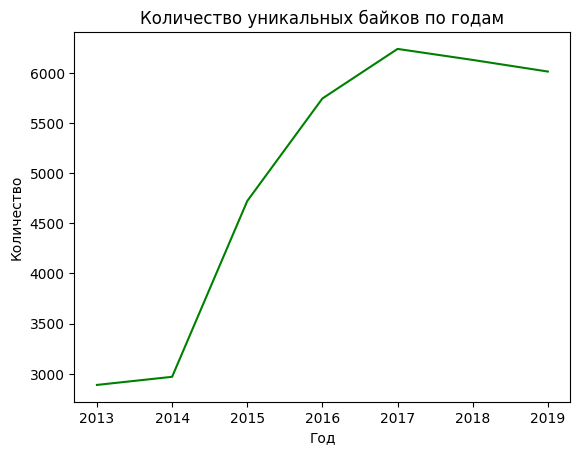

In [15]:
pdf = pd.DataFrame(unique_by_year)
plt.plot(pdf[0], pdf[1], c="green")
plt.title("Количество уникальных байков по годам")
plt.ylabel("Количество")
plt.xlabel("Год")

Text(0.5, 0, 'Год')

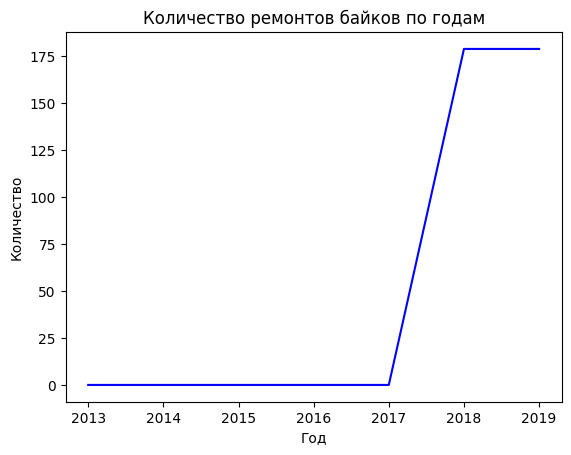

In [16]:
pdf = pd.DataFrame(repairs)
plt.plot(pdf[0], pdf[1], c="blue")
plt.title("Количество ремонтов байков по годам")
plt.ylabel("Количество")
plt.xlabel("Год")

Text(0.5, 0, 'Год')

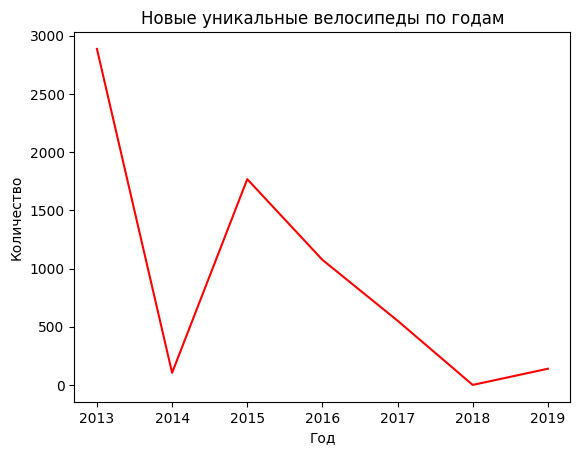

In [17]:
pdf = pd.DataFrame(unique_by_year2)
plt.plot(pdf[0], pdf[1], c="red")
plt.title("Новые уникальные велосипеды по годам")
plt.ylabel("Количество")
plt.xlabel("Год")

Text(0.5, 0, 'Год')

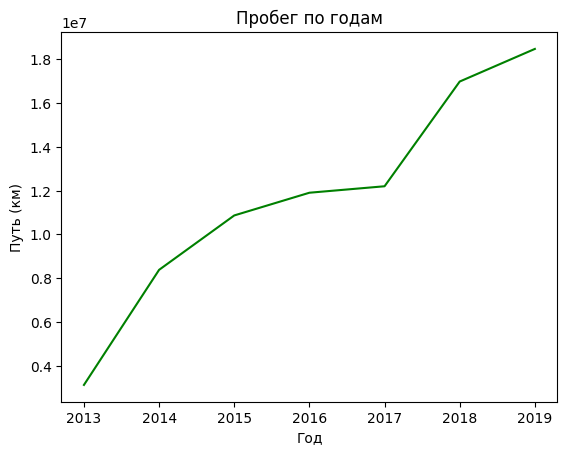

In [18]:
pdf = pd.DataFrame(run)
plt.plot(pdf[0], pdf[1], c="green")
plt.title("Пробег по годам")
plt.ylabel("Путь (км)")
plt.xlabel("Год")

Какие выводы можно сделать из графиков за 2013-2019 года?
1. Велосипедная сеть росла, лишь в 2019 году наблюдается незначительный спад количества уникальных байков
2. В 2016 наблюдается небольшой спад пользования сети (подтверждение о чем можно найти в новостных лентах)
3. График ремонта байков будет цикличен. Divvy основан в 2013 году, в этом году введена большая часть велосипедов этой сети (вторая часть была введена в эксплуатацию после расширения сети в 2015 году). Значит, по истечении 2-х лет количество ремонтов байков достигнет пика, затем снова пойдет спад. В 2018 году идет наложение ремонта сразу двух "подгрупп" велосипедов (2013 + 2015) => Нужно вводить велосипеды в использование равномерно?

In [19]:
ebikes = []
dbikes = []
bikes = []
for year in range(2020, 2024):
    df = pd.read_table(f'data/src/{year}/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')
    ebikes.append(len(df[df['biketype'] == 'electric_bike']))
    dbikes.append(len(df[df['biketype'] == 'docked_bike']))
    bikes.append(len(df[df['biketype'] == 'classic_bike']))

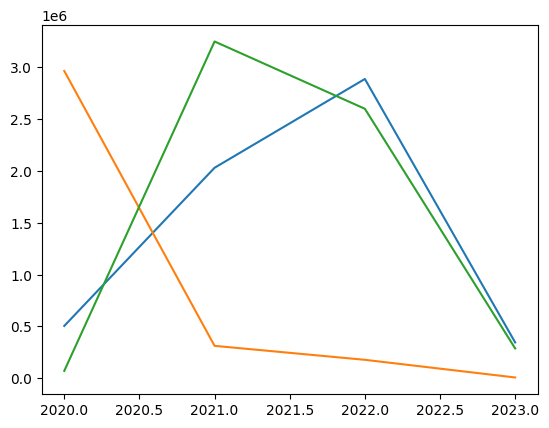

In [20]:
plt.plot(range(2020, 2024), ebikes)
plt.plot(range(2020, 2024), dbikes)
plt.plot(range(2020, 2024), bikes)

### Станции

In [21]:
df = pd.read_table(f'data/src/2023/part-00000', index_col=False, header=None, names=['id', 'biketype', 'starttime', 'endtime', 'startstation', 'endstation', 'startlat', 'startlng', 'endlat', 'endlng', 'member_casual', 'gender', 'age', 'bikeid'], sep=',')
stations = df[['id', 'startstation', 'biketype']].rename(columns={'startstation': 'station'}).groupby(by=['station']).agg({'id': 'count', 'biketype': pd.Series.mode}).reset_index()

In [22]:
stations.sort_values(by=['id'], ascending=False).rename(columns={"id":"count"})[:10]

,station,count,biketype
1009,University Ave & 57th St,5908,classic_bike
265,Ellis Ave & 60th St,5744,classic_bike
179,Clinton St & Washington Blvd,5250,electric_bike
407,Kingsbury St & Kinzie St,4932,classic_bike
152,Clark St & Elm St,4423,classic_bike
106,Canal St & Adams St,4184,classic_bike
175,Clinton St & Madison St,4076,electric_bike
263,Ellis Ave & 55th St,3981,classic_bike
971,State St & Chicago Ave,3979,classic_bike
1042,Wells St & Concord Ln,3815,classic_bike


In [23]:
stations.sort_values(by=['id'], ascending=False).rename(columns={"id":"count"})[:10]

,station,count,biketype
1009,University Ave & 57th St,5908,classic_bike
265,Ellis Ave & 60th St,5744,classic_bike
179,Clinton St & Washington Blvd,5250,electric_bike
407,Kingsbury St & Kinzie St,4932,classic_bike
152,Clark St & Elm St,4423,classic_bike
106,Canal St & Adams St,4184,classic_bike
175,Clinton St & Madison St,4076,electric_bike
263,Ellis Ave & 55th St,3981,classic_bike
971,State St & Chicago Ave,3979,classic_bike
1042,Wells St & Concord Ln,3815,classic_bike


In [24]:
stations = df[['startstation', 'biketype', 'starttime', 'endtime']]
stations['starttime'] = stations['starttime'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S'))
stations['endtime'] = stations['endtime'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S'))
stations['timedelta'] = stations['endtime'] - stations['starttime']
stations['timedelta'] = stations['timedelta'].apply(lambda x: x.total_seconds() / 60)
stations = stations[['startstation', 'biketype', 'timedelta']]
ebikes = stations.loc[(stations['biketype'] == 'electric_bike') | (stations['biketype'] == 'docked_bike')][['startstation', 'timedelta']]
bikes = stations[stations['biketype'] == 'classic_bike'][['startstation', 'timedelta']]
ebikes['output'] = 1 + 0.42 * ebikes['timedelta']
bikes['output'] = 1 + 0.17 * bikes['timedelta']
ebikes = ebikes[['startstation', 'output']].groupby(by='startstation').sum()
bikes = bikes[['startstation', 'output']].groupby(by='startstation').sum()
res = pd.concat([bikes, ebikes]).groupby(by='startstation').sum()
res.sort_values('output')[-10:]

/tmp/ipykernel_4322/371533361.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations['starttime'] = stations['starttime'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S'))
/tmp/ipykernel_4322/371533361.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations['endtime'] = stations['endtime'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S'))
/tmp/ipykernel_4322/371533361.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

,output
startstation,
Michigan Ave & Lake St,20283.316167
Wells St & Concord Ln,20340.985333
Clark St & Elm St,20616.933667
Shedd Aquarium,21393.373000
Clinton St & Washington Blvd,21574.800000
Millennium Park,22233.339500
Michigan Ave & 8th St,23273.117333
Streeter Dr & Grand Ave,28319.435167
DuSable Lake Shore Dr & Monroe St,31684.659167


In [25]:
stations = df[['id', 'startstation', 'startlat', 'startlng']].rename(columns={'startstation': 'station'}).groupby(by=['station']).agg({'id': 'count', 'startlat': 'max', 'startlng': 'max'}).reset_index()
stations['meanlat'], stations['meanlng'] = stations['startlat'].sum() / len(stations), stations['startlng'].sum() / len(stations)
stations['distance'] = ((stations['startlat'] - stations['meanlat']) ** 2 + (stations['startlng'] - stations['meanlng']) ** 2 ) ** 0.5
stations = stations.sort_values('distance')
stations

,station,id,startlat,startlng,meanlat,meanlng,distance
20,Ashland Ave & 13th St,541,41.865410,-87.666345,41.862837,-87.668025,0.003073
584,Paulina St & 18th St,483,41.858061,-87.668262,41.862837,-87.668025,0.004782
55,Blue Island Ave & 18th St,577,41.857585,-87.661279,41.862837,-87.668025,0.008549
1094,Wood St & Taylor St (Temp),967,41.869706,-87.673306,41.862837,-87.668025,0.008664
346,Hermitage Ave & Polk St,1044,41.871689,-87.669276,41.862837,-87.668025,0.008940
...,...,...,...,...,...,...,...
184,Commercial Ave & 130th St,20,41.659213,-87.550708,41.862837,-87.668025,0.235002
613,Public Rack - Avenue M & 132nd St,1,41.660000,-87.540000,41.862837,-87.668025,0.239861
617,Public Rack - Baltimore Ave & 133rd St,5,41.650000,-87.550000,41.862837,-87.668025,0.243371
345,Hegewisch Metra Station,18,41.648607,-87.546090,41.862837,-87.668025,0.246500


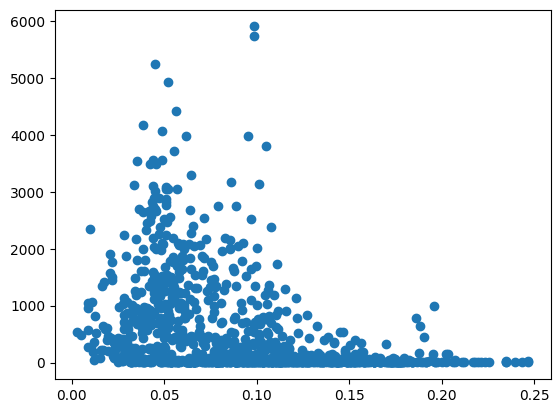

In [26]:
plt.scatter(stations['distance'], stations['id'])

In [27]:
temp = stations
stations = stations.loc[stations['id'] == 1]
stations = stations[['startlat', 'startlng', 'meanlat', 'meanlng']]
stations['lng-lat'] = stations['startlng'].astype(str) + ',' + stations['startlat'].astype(str)
stations = stations[['meanlat', 'meanlng', 'lng-lat']]

In [28]:
API_SERVER = "http://static-maps.yandex.ru/1.x"


def set_request(stations):
    params = {"ll": ",".join([str(round(stations['meanlng'].tolist()[0], 2)), str(round(stations['meanlat'].tolist()[0], 2))]),
              "spn": "0.4,0.4",
              "l": 'map'}
    params['pt'] = '~'.join(stations['lng-lat'].tolist())
    image = requests.get(API_SERVER, params)
    with open('data/map.png', "wb") as file:
        file.write(image.content)

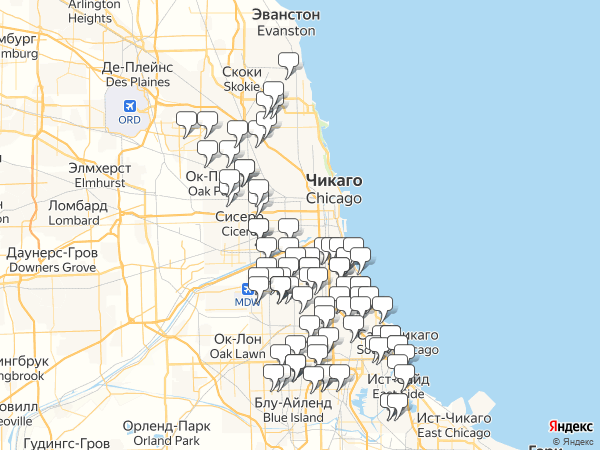

In [29]:
set_request(stations)
Image(filename='data/map.png')

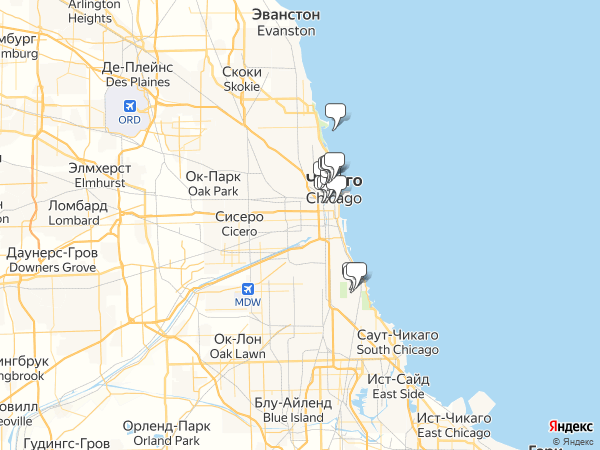

In [30]:
stations = temp
stations = stations.loc[stations['id'] >= 3500]
stations = stations[['startlat', 'startlng', 'meanlat', 'meanlng']]
stations['lng-lat'] = stations['startlng'].astype(str) + ',' + stations['startlat'].astype(str)
stations = stations[['meanlat', 'meanlng', 'lng-lat']]
set_request(stations)
from IPython.display import Image
Image(filename='data/map.png')

In [31]:
stations = df[['startstation', 'id', 'endstation']].dropna()
stations_start = stations[['startstation', 'id']].rename(columns={'id': 'count'}).groupby(by=['startstation']).count()
stations_end = stations[['endstation', 'id']].rename(columns={'id': 'count'}).groupby(by=['endstation']).count()
count = stations_start - stations_end
count = count.dropna()

In [32]:
count.sort_values('count')

,count
Green St & Randolph St*,-594.0
Sangamon St & Lake St,-406.0
St. Clair St & Erie St,-303.0
Clinton St & Madison St,-266.0
Clinton St & Washington Blvd,-237.0
...,...
Carpenter St & Huron St,343.0
Wells St & Huron St,369.0
Desplaines St & Kinzie St,388.0
Columbus Dr & Randolph St,406.0


(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   1.,   0.,   1.,   2.,   0.,   2.,   3.,   7.,   5.,
          4.,  21.,  33.,  44.,  98., 556., 112.,  35.,  20.,  10.,  11.,
          7.,   2.,   4.,   3.,   3.,   2.,   1.,   1.,   0.,   3.,   2.,
          1.,   1.,   1.,   0.,   0.,   1.]),
 array([-594.  , -572.48, -550.96, -529.44, -507.92, -486.4 , -464.88,
        -443.36, -421.84, -400.32, -378.8 , -357.28, -335.76, -314.24,
        -292.72, -271.2 , -249.68, -228.16, -206.64, -185.12, -163.6 ,
        -142.08, -120.56,  -99.04,  -77.52,  -56.  ,  -34.48,  -12.96,
           8.56,   30.08,   51.6 ,   73.12,   94.64,  116.16,  137.68,
         159.2 ,  180.72,  202.24,  223.76,  245.28,  266.8 ,  288.32,
         309.84,  331.36,  352.88,  374.4 ,  395.92,  417.44,  438.96,
         460.48,  482.  ]),
 <BarContainer object of 50 artists>)

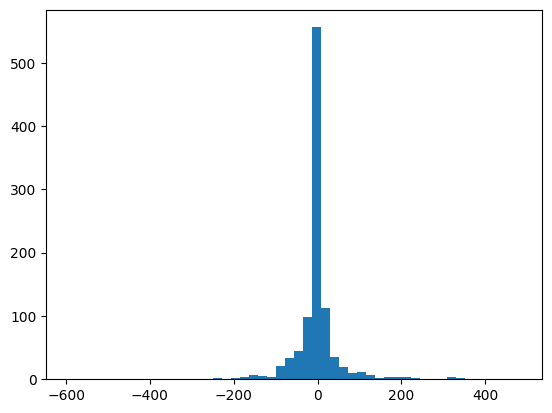

In [33]:
plt.hist(count['count'], bins=50)

### Экономика

## Заключение